In [191]:
# Import python packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
#import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Load imputed Houston data
df_spokane = pd.read_pickle("spokane_df.pkl")




In [192]:
print(df_spokane)

df_spokane_raw = df_spokane.copy()

                  cuisine product_type    revenue       cost   cases  \
3040                Asian     Non Food   10081.22    6706.49   277.0   
3041                Asian     Non Food    9397.72    6441.59   271.0   
3042                Asian     Non Food   10057.14    6067.77   259.0   
3043                Asian     Non Food   10949.23    6328.36   274.0   
3044                Asian     Non Food    8841.24    5511.04   235.0   
...                   ...          ...        ...        ...     ...   
4555  Mainstream American     Proteins  401062.70  330175.69  3996.0   
4556  Mainstream American     Proteins  355862.00  291755.74  4508.0   
4557  Mainstream American     Proteins  361922.86  291624.85  4162.0   
4558  Mainstream American     Proteins  427036.32  349320.10  4367.0   
4559  Mainstream American     Proteins  317565.78  284939.94  3616.0   

      customer_count     city       week  
3040            29.0  SPOKANE 2020-06-29  
3041            26.0  SPOKANE 2020-07-06  
3042  

In [193]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variable representing the time steps
x=np.array(range(len(df_spokane))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, df_spokane['revenue'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
df_spokane['Linear model']=predictions

# calculate the root mean squared error
rmse=sqrt(mean_squared_error(df_spokane['revenue'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 77555.9


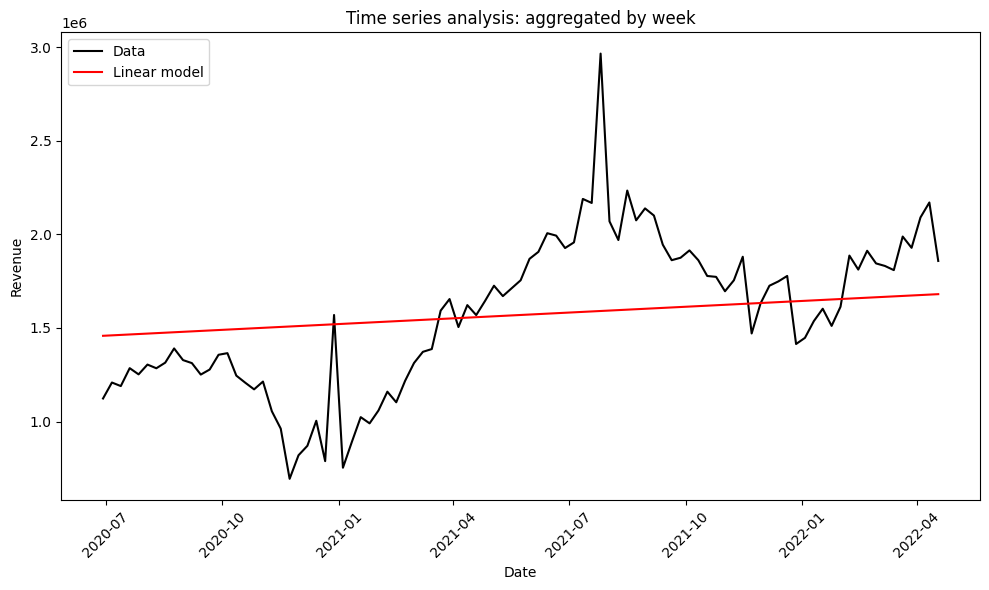

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

#Ensure 'week' is datetime
df_spokane['week'] = pd.to_datetime(df_spokane['week'])

#Aggregate revenue and linear model by week
df_weekly = df_spokane.groupby('week', as_index=False)[['revenue', 'Linear model']].sum()


plt.figure(figsize=(10, 6))
plt.plot(df_weekly['week'], df_weekly['revenue'], label='Data', color='black')
plt.plot(df_weekly['week'], df_weekly['Linear model'], label='Linear model', color='red')

plt.title('Time series analysis: aggregated by week')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [166]:
weekly_revenue = df_spokane.groupby('week')['revenue'].sum().asfreq('W-MON')

In [167]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(df_spokane['revenue'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.101


Not stationary- will use differencing

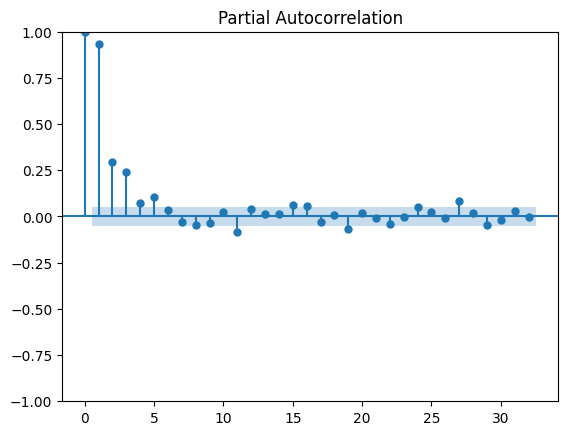

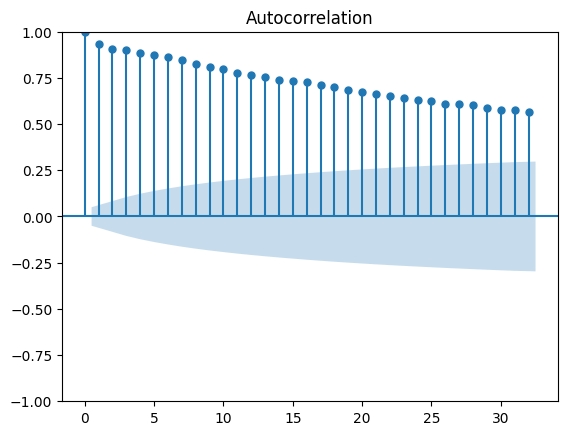

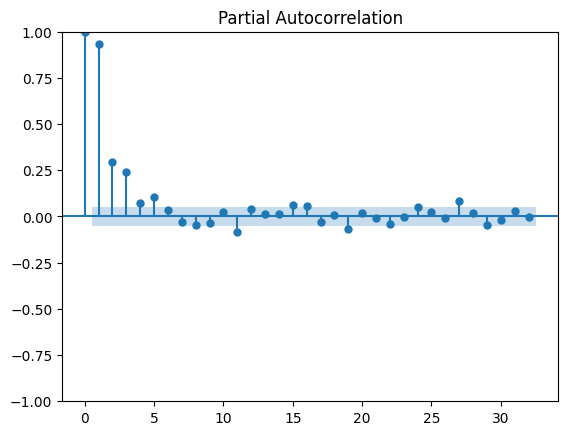

In [168]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_houston['revenue'])
plot_pacf(df_houston['revenue'])

In [169]:
df_spokane['log_revenue'] = np.log(df_spokane['revenue'])


In [170]:
import statsmodels.api as sm

order = (0, 1, 1)
seasonal_order = (0, 1, 1, 12)

model = sm.tsa.SARIMAX(df_spokane['log_revenue'], order=order, seasonal_order=seasonal_order).fit()

print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        log_revenue   No. Observations:                 1520
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -38.705
Date:                            Mon, 16 Jun 2025   AIC                             83.410
Time:                                    09:17:14   BIC                             99.364
Sample:                                         0   HQIC                            89.352
                                           - 1520                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4890      0.009    -54.279      0.000      -0.507      -0.471
ma.S.L12      -0.9992      0.226   

Model is well-specified: MA terms are statistically significant.
No autocorrelation in residuals (Ljung-Box test)
Residuals are not normal and show heteroskedasticity

In [171]:
#weekly_revenue_diff = weekly_revenue.diff().dropna()

In [172]:
from statsmodels.tsa.arima.model import ARIMA

# Use raw (undifferenced) weekly revenue
model = ARIMA(weekly_revenue, order=(1, 1, 1))
fitted = model.fit()

# Forecast future values (already reintegrated by the model)
forecast = fitted.forecast(steps=12)

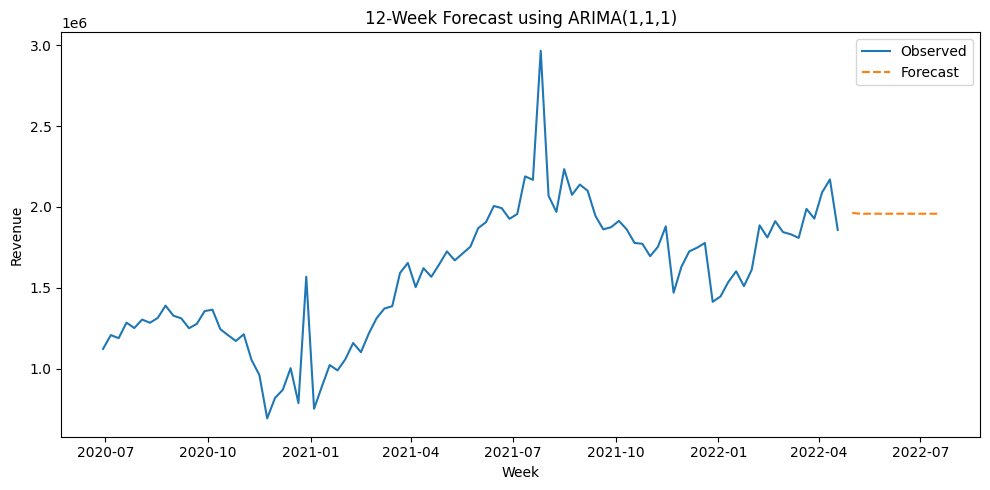

In [173]:


# Reintegrate (undo differencing)
# last_observed = weekly_revenue.iloc[-1]
# forecast = forecast_diff.cumsum() + last_observed

# Plot
plt.figure(figsize=(10, 5))
plt.plot(weekly_revenue.index, weekly_revenue, label='Observed')
plt.plot(pd.date_range(weekly_revenue.index[-1], periods=13, freq='W')[1:], forecast, label='Forecast', linestyle='--')
plt.title("12-Week Forecast using ARIMA(1,1,1)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

In [174]:
for p in range(0, 4):
    for d in range(1, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(df['revenue'], order=(p, d, q))
                results = model.fit()
                print(f'ARIMA({p},{d},{q}) AIC: {results.aic}')
            except:
                continue

In [175]:
ts = df_spokane['revenue']  # or weekly_revenue, etc.

In [176]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(1, 3):  
        for q in range(0, 4):
            try:
                model = ARIMA(ts, order=(p, d, q))
                result = model.fit()
                aic = result.aic
                print(f'ARIMA({p},{d},{q}) AIC: {aic:.2f}')
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = result
            except:
                continue

print(f'\n✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')

ARIMA(0,1,0) AIC: 36268.65
ARIMA(0,1,1) AIC: 35953.89
ARIMA(0,1,2) AIC: 35942.92
ARIMA(0,1,3) AIC: 35937.61
ARIMA(0,2,0) AIC: 37739.70
ARIMA(0,2,1) AIC: 36296.21
ARIMA(0,2,2) AIC: 35994.31
ARIMA(0,2,3) AIC: 35929.16
ARIMA(1,1,0) AIC: 36082.15
ARIMA(1,1,1) AIC: 35945.95
ARIMA(1,1,2) AIC: 35937.36
ARIMA(1,1,3) AIC: 35938.94
ARIMA(1,2,0) AIC: 37115.46
ARIMA(1,2,1) AIC: 36150.15
ARIMA(1,2,2) AIC: 35969.50
ARIMA(1,2,3) AIC: 35933.03
ARIMA(2,1,0) AIC: 35970.70
ARIMA(2,1,1) AIC: 35940.21
ARIMA(2,1,2) AIC: 35938.93
ARIMA(2,1,3) AIC: 35938.48
ARIMA(2,2,0) AIC: 36694.49
ARIMA(2,2,1) AIC: 36058.88
ARIMA(2,2,2) AIC: 35947.56
ARIMA(2,2,3) AIC: 35944.89
ARIMA(3,1,0) AIC: 35958.86
ARIMA(3,1,1) AIC: 35941.96
ARIMA(3,1,2) AIC: 35940.92
ARIMA(3,1,3) AIC: 35938.56
ARIMA(3,2,0) AIC: 36540.32
ARIMA(3,2,1) AIC: 36051.71
ARIMA(3,2,2) AIC: 35973.32
ARIMA(3,2,3) AIC: 35940.11

✅ Best ARIMA order: (0, 2, 3) with AIC: 35929.16


In [177]:
best_order = (0, 2, 3)

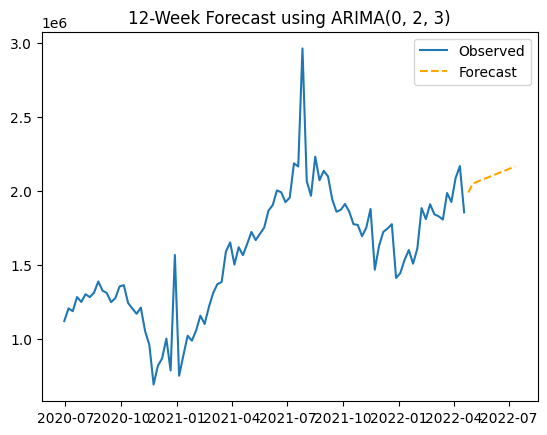

In [178]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(weekly_revenue, order=best_order)
fitted = model.fit()

forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using ARIMA{best_order}")
plt.legend()
plt.show()

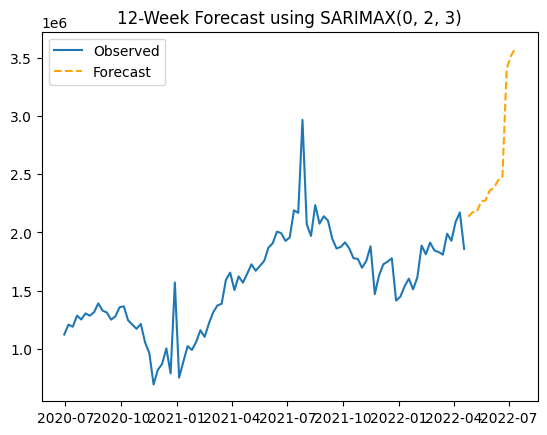

In [179]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(weekly_revenue, order=(3, 2, 3), seasonal_order=(1, 1, 1, 52))
fitted = model.fit()
forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using SARIMAX{best_order}")
plt.legend()
plt.show()

Going to get ACF plot to help determine best s value


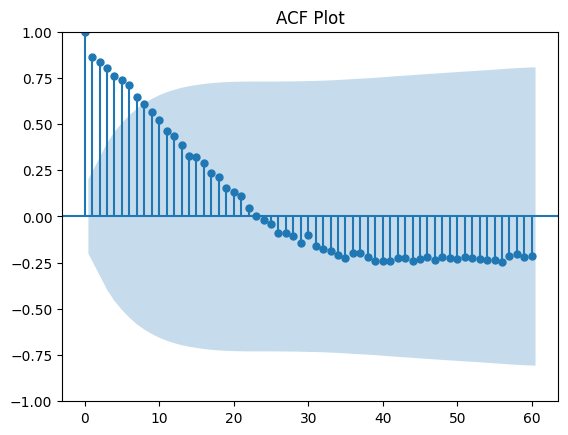

In [180]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(weekly_revenue, lags=60)
plt.title("ACF Plot")
plt.show()

In [181]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_candidates = [1, 4, 13, 26, 52]
aic_scores = []

for s in seasonal_candidates:
    try:
        model = SARIMAX(weekly_revenue, order=(1, 1, 1), seasonal_order=(1, 1, 1, s))
        fit = model.fit(disp=False)
        aic_scores.append((s, fit.aic))
    except:
        continue

aic_scores.sort(key=lambda x: x[1])
print("Best seasonal period by AIC:", aic_scores[0])

Best seasonal period by AIC: (52, np.float64(1156.4156836119198))


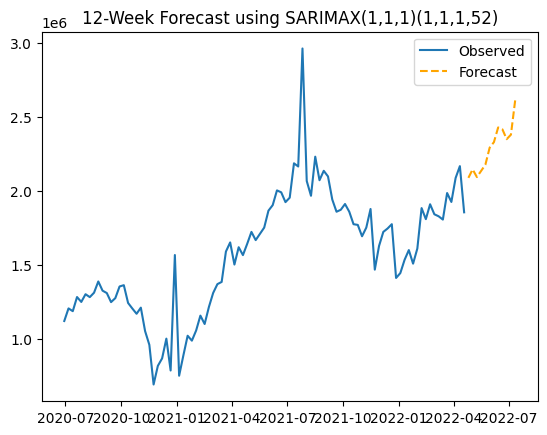

In [182]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(1, 1, 1),                
    seasonal_order=(1, 1, 1, 52),   
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMAX(1,1,1)(1,1,1,52)")
plt.legend()
plt.show()

In [183]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], 1, x[2], 52) for x in pdq]

lowest_aic = float("inf")
best_config = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                weekly_revenue,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_config = (param, param_seasonal)
        except:
            continue

print("Best SARIMA config:", best_config)
print("Lowest AIC:", lowest_aic)

Best SARIMA config: ((0, 1, 0), (0, 1, 1, 52))
Lowest AIC: 4.0


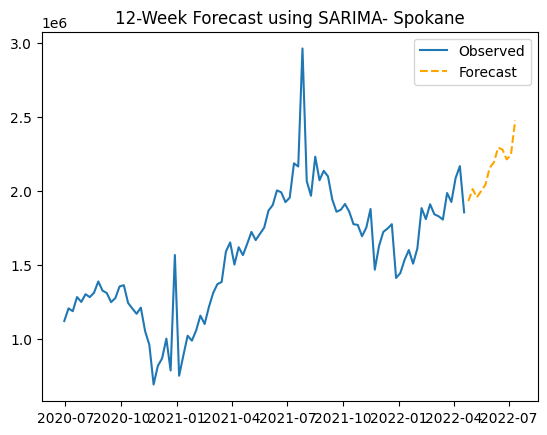

In [184]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(0, 1, 0),                # Simpler ARIMA
    seasonal_order=(0, 1, 1, 52),   # Annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMA- Spokane")
plt.legend()
plt.show()

In [185]:
forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean


print("12-Week Forecast Values:")
print(forecast_values)

12-Week Forecast Values:
2022-04-25    1934027.75
2022-05-02    2014917.01
2022-05-09    1959424.33
2022-05-16    2001748.84
2022-05-23    2043937.75
2022-05-30    2158457.51
2022-06-06    2195745.85
2022-06-13    2295380.16
2022-06-20    2282393.66
2022-06-27    2216070.38
2022-07-04    2246246.08
2022-07-11    2478430.40
Freq: W-MON, Name: predicted_mean, dtype: float64


In [186]:

forecast_df = forecast.predicted_mean.to_frame(name="forecast")

forecast_df.to_pickle("Spokane_forecast_12_weeks.pkl")
forecast_df.to_csv("Spokane_forecast_12_weeks.csv")


Going to do some test/train split and run with this model

In [187]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon= 12

# Set a model order, i.e. how many past data points should be used as input for prediction
model_order=100

In [188]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(df_spokane) - testing_dataset_size

# Get the training and testing sets
training_data=df_spokane[:training_set_size]
testing_data=df_spokane[training_set_size:]

In [189]:
# Ensure 'week' is datetime
df_spokane['week'] = pd.to_datetime(df_spokane['week'])

# Group by week + city, sum revenue and other relevant columns
df_spokane_agg = df_spokane.groupby(['week', 'city'], as_index=False).agg({
    'revenue': 'sum',
    'cost': 'sum',
    'cases': 'sum',
    'customer_count': 'sum'
})

# Optional: Just filter for one city (if modeling per-city)
df_spokane_city = df_spokane_agg[df_spokane_agg['city'] == 'HOUSTON'].copy()

# Set week as index and sort
df_spokane_city = df_spokane_city.sort_values('week')
df_spokane_city.set_index('week', inplace=True)

# Add log transform
df_spokane_city['log_revenue'] = np.log(df_spokane_city['revenue'])

Datetime index type: <class 'pandas.core.indexes.base.Index'>
First few rows:      cuisine product_type   revenue     cost  cases  customer_count     city  \
3040   Asian     Non Food  10081.22  6706.49  277.0            29.0  SPOKANE   
3041   Asian     Non Food   9397.72  6441.59  271.0            26.0  SPOKANE   
3042   Asian     Non Food  10057.14  6067.77  259.0            26.0  SPOKANE   
3043   Asian     Non Food  10949.23  6328.36  274.0            26.0  SPOKANE   
3044   Asian     Non Food   8841.24  5511.04  235.0            26.0  SPOKANE   

           week  Linear model  log_revenue  
3040 2020-06-29 -14205.534028     9.218430  
3041 2020-07-06 -14057.686546     9.148222  
3042 2020-07-13 -13909.839064     9.216038  
3043 2020-07-20 -13761.991582     9.301024  
3044 2020-07-27 -13614.144100     9.087182  


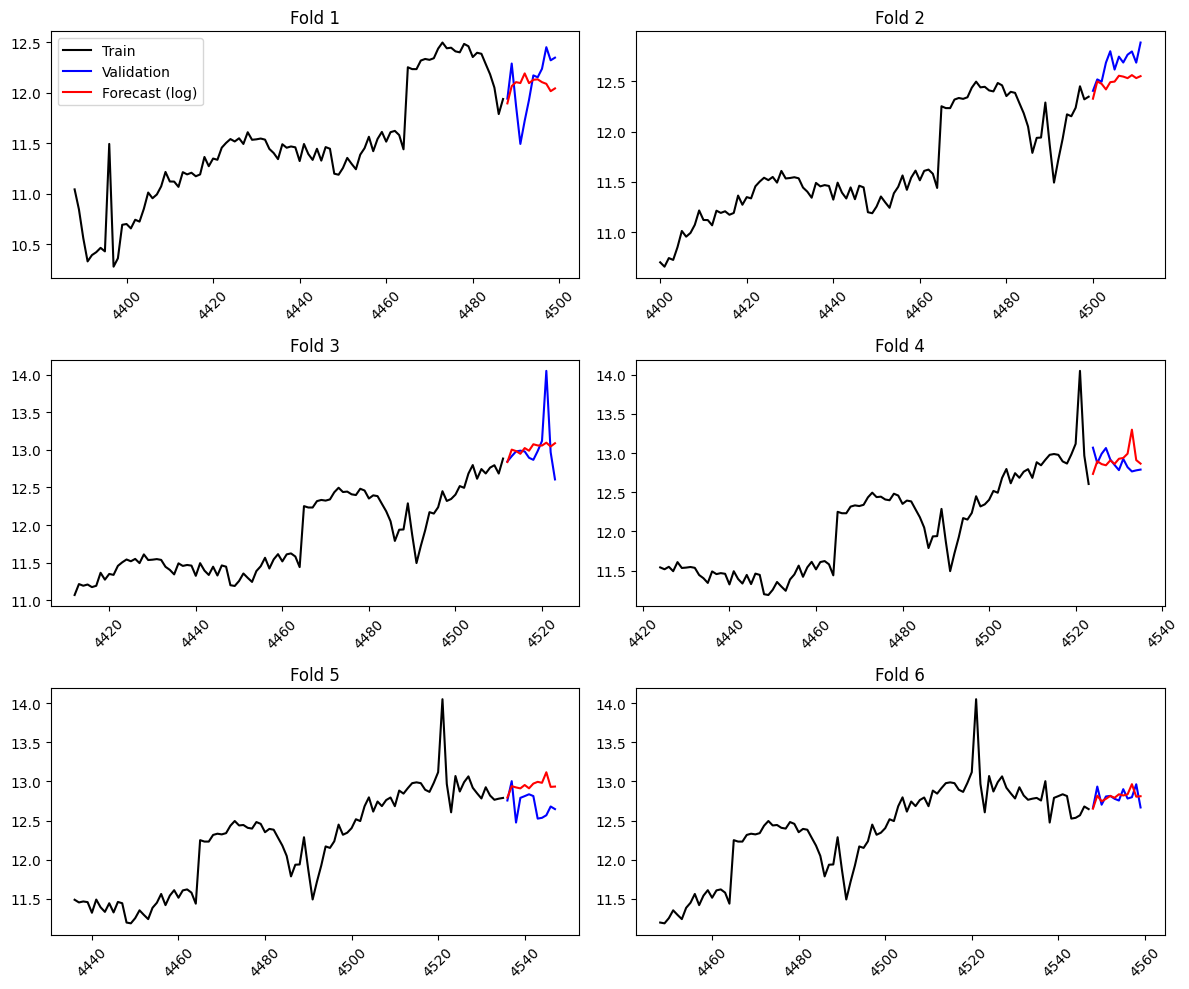


Average RMSE across folds (original revenue scale): 97,502.31


In [190]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Just sort by the index since 'week' is already set as index
df_spokane = df_spokane.sort_index()

# Optional sanity check
print("Datetime index type:", type(df_spokane.index))
print("First few rows:", df_spokane.head())

# Parameters
folds = 6
forecast_horizon = 12
model_order = 100  # min training size for SARIMA to stabilize

# Holders
validation_rmse_values = []
predicted_values = []
validation_values = []

# Set up plots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Cross-validation loop
for i, (train_idx, val_idx) in enumerate(tscv.split(df_spokane)):

    train = df_spokane.iloc[train_idx]
    val = df_spokane.iloc[val_idx]

    # Fit model
    model = SARIMAX(train['log_revenue'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.forecast(steps=len(val))

    # Back-transform
    forecast_exp = np.exp(forecast)
    actual_exp = np.exp(val['log_revenue'])

    # Save for global RMSE later
    predicted_values.extend(forecast_exp)
    validation_values.extend(actual_exp)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(actual_exp, forecast_exp))
    validation_rmse_values.append(rmse)

    # Plot
    axs[i].plot(train.index, train['log_revenue'], label='Train', color='black')
    axs[i].plot(val.index, val['log_revenue'], label='Validation', color='blue')
    axs[i].plot(val.index, forecast, label='Forecast (log)', color='red')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].tick_params(axis='x', labelrotation=45)

    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()

# Final RMSE summary
if validation_rmse_values:
    print(f"\nAverage RMSE across folds (original revenue scale): {np.mean(validation_rmse_values):,.2f}")
else:
    print("\nNo valid RMSE values calculated.")